In [130]:
import yfinance as yf
from typing import List
from pandas_datareader import data as pdr
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from docopt import docopt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown, display
import plotly.express as px

def get_financial_time_series(symbol: str, start_date: str, end_date: str,
                              type: List[str] = ('Date','Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','LIBOR')):
    return pdr.get_data_yahoo(symbol, start=start_date, end=end_date)[type]

if __name__ == "__main__":
    start, end = "2002-01-01", "2019-01-01"
    print(get_financial_time_series("GME", start, end, ['Open', 'High', 'Low', 'Close']))
    GME_stock = get_financial_time_series("GME", start, end, ['Open', 'High', 'Low', 'Close']).reset_index()
    GME_stock['Date'] = pd.to_datetime(GME_stock['Date'])
    GME_stock.head()

              Open    High     Low   Close
Date                                      
2002-02-13   9.625  10.060   9.525  10.050
2002-02-14  10.175  10.195   9.925  10.000
2002-02-15  10.000  10.025   9.850   9.950
2002-02-19   9.900   9.900   9.375   9.550
2002-02-20   9.600   9.875   9.525   9.875
...            ...     ...     ...     ...
2018-12-24  11.970  12.020  11.640  11.670
2018-12-26  11.720  12.400  11.560  12.400
2018-12-27  12.240  12.250  11.630  12.180
2018-12-28  12.210  12.490  12.010  12.280
2018-12-31  12.330  12.670  12.310  12.620

[4250 rows x 4 columns]


In [131]:
Pt = GME_stock.loc[:,'Close']
Pt_prev = GME_stock.loc[1:,'Close'].reset_index(drop=True)
rt = 100*(np.log(Pt[:-1]) - np.log(Pt_prev))
rt = pd.concat([pd.Series([np.nan]), rt]).reset_index(drop=True)
GME_stock['rt'] = rt
df_rt = GME_stock.dropna().reset_index(drop=True)
df_rt

Date    Open    High     Low   Close        rt
0    2002-02-14  10.175  10.195   9.925  10.000  0.498756
1    2002-02-15  10.000  10.025   9.850   9.950  0.501256
2    2002-02-19   9.900   9.900   9.375   9.550  4.103136
3    2002-02-20   9.600   9.875   9.525   9.875 -3.346514
4    2002-02-21   9.840   9.925   9.750   9.850  0.253482
...         ...     ...     ...     ...     ...       ...
4244 2018-12-24  11.970  12.020  11.640  11.670  2.454630
4245 2018-12-26  11.720  12.400  11.560  12.400 -6.067499
4246 2018-12-27  12.240  12.250  11.630  12.180  1.790115
4247 2018-12-28  12.210  12.490  12.010  12.280 -0.817661
4248 2018-12-31  12.330  12.670  12.310  12.620 -2.731095

[4249 rows x 6 columns]

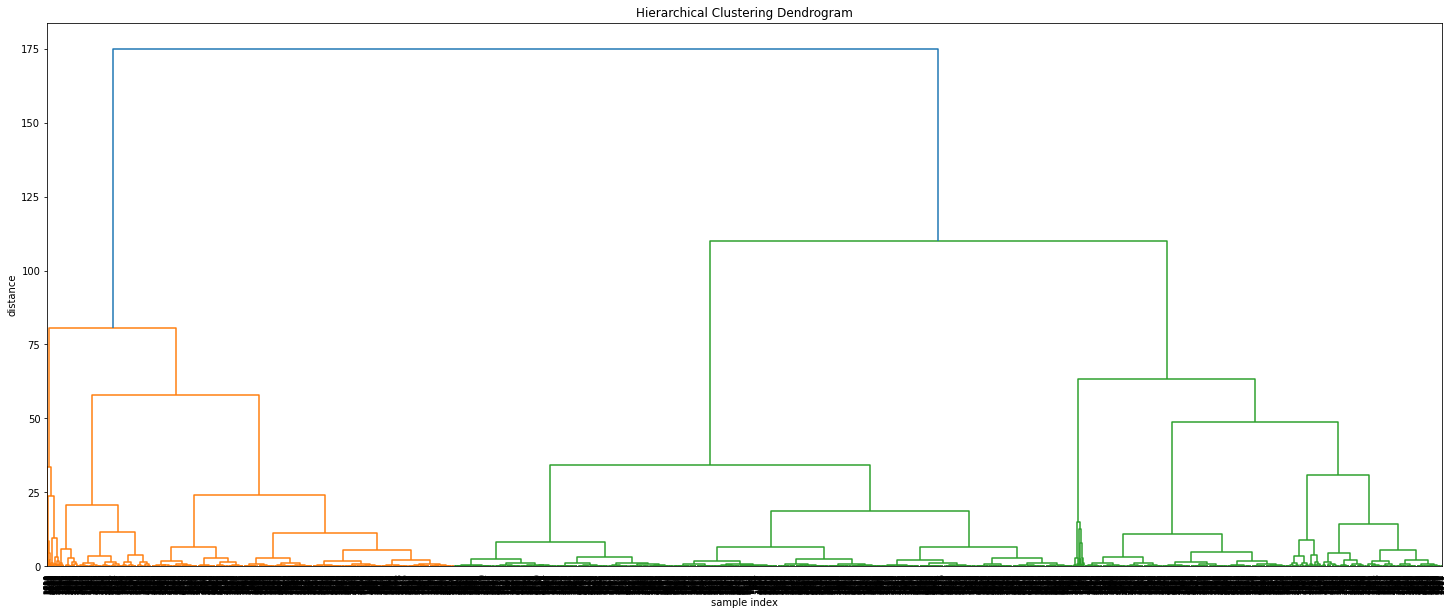

In [132]:
from scipy.cluster import hierarchy as hac

Y = df_rt.loc[:,'rt'].values
Z = hac.linkage(np.reshape(Y, (len(Y), 1)), method='ward', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [133]:
from sklearn.mixture import GaussianMixture as GMM
import plotly.graph_objects as go

Y = df_rt['rt'].values.reshape(-1,1)

L= np.arange(1,100,1)
clfs= [GMM(n,covariance_type='full').fit(Y) for n in L]
aics= [clf.aic(Y) for clf in clfs]
bics= [clf.bic(Y) for clf in clfs]


fig = go.Figure()
fig.add_trace(go.Scatter(x=L, y=aics,
                      mode='lines+markers',
                    name='lines+markers'))

fig.add_trace(go.Scatter(x=L, y=bics,
                    mode='lines+markers',
                    name='lines+markers'))
fig.show()

In [204]:
L = 5#4

Y = df_rt['rt'].values.reshape(-1,1)
GMM_cluster = GMM(L,covariance_type='full').fit(Y)
df_rt['cls'] = GMM_cluster.predict(Y)
df = px.data.iris()
fig = px.scatter(df_rt, x="Date", y="rt", color="cls", hover_data=df_rt.columns.to_list())
fig.show()

In [205]:
fig = px.scatter(df_rt, x="Date", y="Close", color="cls", hover_data=df_rt.columns.to_list())
fig.show()

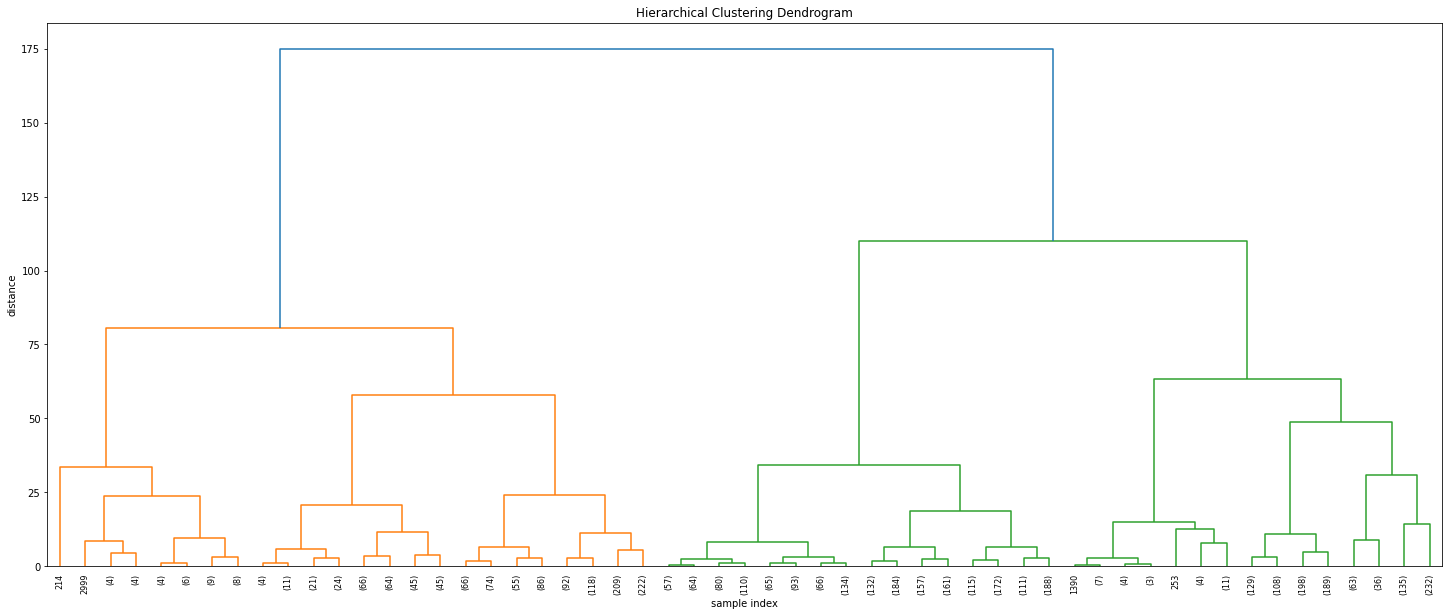

In [206]:
### from scipy.cluster import hierarchy as hac

Y = df_rt.loc[:,'rt'].values
Z = hac.linkage(np.reshape(Y, (len(Y), 1)), method='ward', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='level', p=L
)
plt.show()

In [207]:
df_rt

Date    Open    High     Low   Close        rt  cls  rt_cls_mean
0    2002-02-14  10.175  10.195   9.925  10.000  0.498756    2     0.059959
1    2002-02-15  10.000  10.025   9.850   9.950  0.501256    2     0.059959
2    2002-02-19   9.900   9.900   9.375   9.550  4.103136    1     2.853259
3    2002-02-20   9.600   9.875   9.525   9.875 -3.346514    0     0.059959
4    2002-02-21   9.840   9.925   9.750   9.850  0.253482    2     0.059959
...         ...     ...     ...     ...     ...       ...  ...          ...
4244 2018-12-24  11.970  12.020  11.640  11.670  2.454630    1     0.059959
4245 2018-12-26  11.720  12.400  11.560  12.400 -6.067499    4     2.853259
4246 2018-12-27  12.240  12.250  11.630  12.180  1.790115    1     0.059959
4247 2018-12-28  12.210  12.490  12.010  12.280 -0.817661    2     0.059959
4248 2018-12-31  12.330  12.670  12.310  12.620 -2.731095    0     0.059959

[4249 rows x 8 columns]

In [208]:
result_dict = df_rt.groupby('cls').agg({'rt': [np.min,np.max,np.mean]}).to_dict()
df_rt.loc[:, 'rt_cls_mean'] = df_rt['cls'].map(result_dict[('rt', 'mean')])
df_rt

Date    Open    High     Low   Close        rt  cls  rt_cls_mean
0    2002-02-14  10.175  10.195   9.925  10.000  0.498756    2    -0.024815
1    2002-02-15  10.000  10.025   9.850   9.950  0.501256    2    -0.024815
2    2002-02-19   9.900   9.900   9.375   9.550  4.103136    1     2.891712
3    2002-02-20   9.600   9.875   9.525   9.875 -3.346514    0    -2.652692
4    2002-02-21   9.840   9.925   9.750   9.850  0.253482    2    -0.024815
...         ...     ...     ...     ...     ...       ...  ...          ...
4244 2018-12-24  11.970  12.020  11.640  11.670  2.454630    1     2.891712
4245 2018-12-26  11.720  12.400  11.560  12.400 -6.067499    4    -6.836665
4246 2018-12-27  12.240  12.250  11.630  12.180  1.790115    1     2.891712
4247 2018-12-28  12.210  12.490  12.010  12.280 -0.817661    2    -0.024815
4248 2018-12-31  12.330  12.670  12.310  12.620 -2.731095    0    -2.652692

[4249 rows x 8 columns]

In [211]:
ls = []

def test(x):
    ls.append(x)
    print(x)
    return x[-1]

windows = 10
df_rt.loc[:,['rt_cls_mean']].rolling(window=windows,
                               center=False).apply(test,raw=True)

# np.array(ls)
columns = [f'r_{i}' for i in range(windows)]
df = pd.DataFrame(np.array(ls), columns=columns)
df

[-0.024815   -0.024815    2.8917119  -2.65269219 -0.024815    2.8917119
 -0.024815   -0.024815    2.8917119  -0.024815  ]
[-0.024815    2.8917119  -2.65269219 -0.024815    2.8917119  -0.024815
 -0.024815    2.8917119  -0.024815   -0.024815  ]
[ 2.8917119  -2.65269219 -0.024815    2.8917119  -0.024815   -0.024815
  2.8917119  -0.024815   -0.024815   -2.65269219]
[-2.65269219 -0.024815    2.8917119  -0.024815   -0.024815    2.8917119
 -0.024815   -0.024815   -2.65269219  2.8917119 ]
[-0.024815    2.8917119  -0.024815   -0.024815    2.8917119  -0.024815
 -0.024815   -2.65269219  2.8917119  -0.024815  ]
[ 2.8917119  -0.024815   -0.024815    2.8917119  -0.024815   -0.024815
 -2.65269219  2.8917119  -0.024815   -6.83666542]
[-0.024815   -0.024815    2.8917119  -0.024815   -0.024815   -2.65269219
  2.8917119  -0.024815   -6.83666542 -2.65269219]
[-0.024815    2.8917119  -0.024815   -0.024815   -2.65269219  2.8917119
 -0.024815   -6.83666542 -2.65269219 -0.024815  ]
[ 2.8917119  -0.024815   -0

 -0.024815   -0.024815   -0.024815   -0.024815  ]
[-0.024815  -0.024815  -0.024815  -0.024815  -0.024815  -0.024815
 -0.024815  -0.024815  -0.024815   2.8917119]
[-0.024815  -0.024815  -0.024815  -0.024815  -0.024815  -0.024815
 -0.024815  -0.024815   2.8917119 -0.024815 ]
[-0.024815   -0.024815   -0.024815   -0.024815   -0.024815   -0.024815
 -0.024815    2.8917119  -0.024815   -2.65269219]
[-0.024815   -0.024815   -0.024815   -0.024815   -0.024815   -0.024815
  2.8917119  -0.024815   -2.65269219 -0.024815  ]
[-0.024815   -0.024815   -0.024815   -0.024815   -0.024815    2.8917119
 -0.024815   -2.65269219 -0.024815    2.8917119 ]
[-0.024815   -0.024815   -0.024815   -0.024815    2.8917119  -0.024815
 -2.65269219 -0.024815    2.8917119  -2.65269219]
[-0.024815   -0.024815   -0.024815    2.8917119  -0.024815   -2.65269219
 -0.024815    2.8917119  -2.65269219 -0.024815  ]
[-0.024815   -0.024815    2.8917119  -0.024815   -2.65269219 -0.024815
  2.8917119  -2.65269219 -0.024815   -2.6526921

 -0.024815    2.8917119  -0.024815   -0.024815  ]
[-0.024815   -0.024815   -2.65269219 -0.024815   -0.024815   -0.024815
  2.8917119  -0.024815   -0.024815   -0.024815  ]
[-0.024815   -2.65269219 -0.024815   -0.024815   -0.024815    2.8917119
 -0.024815   -0.024815   -0.024815   -0.024815  ]
[-2.65269219 -0.024815   -0.024815   -0.024815    2.8917119  -0.024815
 -0.024815   -0.024815   -0.024815    2.8917119 ]
[-0.024815  -0.024815  -0.024815   2.8917119 -0.024815  -0.024815
 -0.024815  -0.024815   2.8917119 -0.024815 ]
[-0.024815  -0.024815   2.8917119 -0.024815  -0.024815  -0.024815
 -0.024815   2.8917119 -0.024815  -0.024815 ]
[-0.024815    2.8917119  -0.024815   -0.024815   -0.024815   -0.024815
  2.8917119  -0.024815   -0.024815   -2.65269219]
[ 2.8917119  -0.024815   -0.024815   -0.024815   -0.024815    2.8917119
 -0.024815   -0.024815   -2.65269219  2.8917119 ]
[-0.024815   -0.024815   -0.024815   -0.024815    2.8917119  -0.024815
 -0.024815   -2.65269219  2.8917119   2.8917119 

  2.8917119  -2.65269219 -0.024815   -0.024815  ]
[-0.024815   -0.024815   -2.65269219  2.8917119  -0.024815    2.8917119
 -2.65269219 -0.024815   -0.024815   -0.024815  ]
[-0.024815   -2.65269219  2.8917119  -0.024815    2.8917119  -2.65269219
 -0.024815   -0.024815   -0.024815   -2.65269219]
[-2.65269219  2.8917119  -0.024815    2.8917119  -2.65269219 -0.024815
 -0.024815   -0.024815   -2.65269219 -0.024815  ]
[ 2.8917119  -0.024815    2.8917119  -2.65269219 -0.024815   -0.024815
 -0.024815   -2.65269219 -0.024815    2.8917119 ]
[-0.024815    2.8917119  -2.65269219 -0.024815   -0.024815   -0.024815
 -2.65269219 -0.024815    2.8917119  -2.65269219]
[ 2.8917119  -2.65269219 -0.024815   -0.024815   -0.024815   -2.65269219
 -0.024815    2.8917119  -2.65269219 -0.024815  ]
[-2.65269219 -0.024815   -0.024815   -0.024815   -2.65269219 -0.024815
  2.8917119  -2.65269219 -0.024815    2.8917119 ]
[-0.024815   -0.024815   -0.024815   -2.65269219 -0.024815    2.8917119
 -2.65269219 -0.024815    

 -0.024815   -0.024815   -0.024815   -0.024815  ]
[-0.024815   -0.024815   -0.024815   -2.65269219 -2.65269219 -0.024815
 -0.024815   -0.024815   -0.024815   -0.024815  ]
[-0.024815   -0.024815   -2.65269219 -2.65269219 -0.024815   -0.024815
 -0.024815   -0.024815   -0.024815    2.8917119 ]
[-0.024815   -2.65269219 -2.65269219 -0.024815   -0.024815   -0.024815
 -0.024815   -0.024815    2.8917119  -2.65269219]
[-2.65269219 -2.65269219 -0.024815   -0.024815   -0.024815   -0.024815
 -0.024815    2.8917119  -2.65269219 -0.024815  ]
[-2.65269219 -0.024815   -0.024815   -0.024815   -0.024815   -0.024815
  2.8917119  -2.65269219 -0.024815   -0.024815  ]
[-0.024815   -0.024815   -0.024815   -0.024815   -0.024815    2.8917119
 -2.65269219 -0.024815   -0.024815   -0.024815  ]
[-0.024815   -0.024815   -0.024815   -0.024815    2.8917119  -2.65269219
 -0.024815   -0.024815   -0.024815   -0.024815  ]
[-0.024815   -0.024815   -0.024815    2.8917119  -2.65269219 -0.024815
 -0.024815   -0.024815   -0.0

 -0.024815   -0.024815   -0.024815   -2.65269219]
[ 2.8917119   2.8917119  -6.83666542  7.37321659 -0.024815   -0.024815
 -0.024815   -0.024815   -2.65269219 -2.65269219]
[ 2.8917119  -6.83666542  7.37321659 -0.024815   -0.024815   -0.024815
 -0.024815   -2.65269219 -2.65269219 -0.024815  ]
[-6.83666542  7.37321659 -0.024815   -0.024815   -0.024815   -0.024815
 -2.65269219 -2.65269219 -0.024815   -0.024815  ]
[ 7.37321659 -0.024815   -0.024815   -0.024815   -0.024815   -2.65269219
 -2.65269219 -0.024815   -0.024815   -0.024815  ]
[-0.024815   -0.024815   -0.024815   -0.024815   -2.65269219 -2.65269219
 -0.024815   -0.024815   -0.024815   -0.024815  ]
[-0.024815   -0.024815   -0.024815   -2.65269219 -2.65269219 -0.024815
 -0.024815   -0.024815   -0.024815   -0.024815  ]
[-0.024815   -0.024815   -2.65269219 -2.65269219 -0.024815   -0.024815
 -0.024815   -0.024815   -0.024815   -0.024815  ]
[-0.024815   -2.65269219 -2.65269219 -0.024815   -0.024815   -0.024815
 -0.024815   -0.024815   -0.

r_0       r_1       r_2       r_3       r_4       r_5       r_6  \
0    -0.024815 -0.024815  2.891712 -2.652692 -0.024815  2.891712 -0.024815   
1     0.024815  0.024815  2.891712  2.652692  0.024815  2.891712  0.024815   
2     0.024815  0.024815  2.891712  2.652692  0.024815  2.891712  0.024815   
3     0.024815  0.024815  2.891712  2.652692  0.024815  2.891712  0.024815   
4     0.024815  0.024815  2.891712  2.652692  0.024815  2.891712  0.024815   
...        ...       ...       ...       ...       ...       ...       ...   
4235  0.024815  0.024815  2.891712  2.652692  0.024815  2.891712  0.024815   
4236  0.024815  0.024815  2.891712  2.652692  0.024815  2.891712  0.024815   
4237  0.024815  0.024815  2.891712  2.652692  0.024815  2.891712  0.024815   
4238  0.024815  0.024815  2.891712  2.652692  0.024815  2.891712  0.024815   
4239  0.024815  0.024815  2.891712  2.652692  0.024815  2.891712  0.024815   

           r_7       r_8       r_9  
0    -0.024815  2.891712 -0.024815  
1     0.024815  2.891712  0.024815  
2     0.024815  2.891712  0.024815  
3     0.024815  2.891712  0.024815  
4     0.024815  2.891712  0.024815  
...        ...       ...       ...  
4235  0.024815  2.891712  0.024815  
4236  0.024815  2.891712  0.024815  
4237  0.024815  2.891712  0.024815  
4238  0.024815  2.891712  0.024815  
4239  0.024815  2.891712  0.024815  

[4240 rows x 10 columns]

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Plot based on BayesianModel


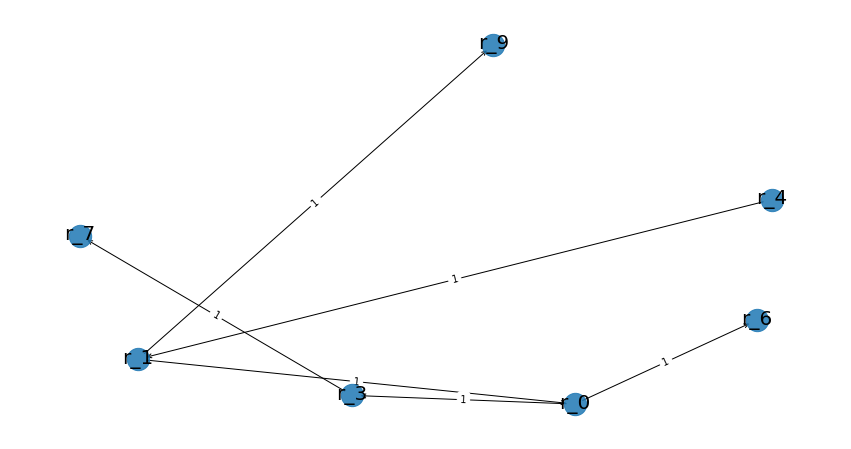

In [212]:
import bnlearn
import networkx as nx

%matplotlib inline
model_hc_bic  = bnlearn.structure_learning.fit(df, methodtype='hc', scoretype='bic')
G = bnlearn.plot(model_hc_bic)
plt.show()

In [158]:
G

{'pos': {'r_0': array([-0.55278098,  0.81678462]),
  'r_1': array([ 0.70061989, -0.35524373]),
  'r_2': array([ 0.71415981, -0.77907735]),
  'r_3': array([-0.85978534, -0.17702904]),
  'r_4': array([ 0.01282023, -0.99622092]),
  'r_5': array([0.93624922, 0.12161149]),
  'r_6': array([-0.59980145, -0.72090897]),
  'r_7': array([0.03452521, 0.99257005]),
  'r_8': array([-1.        ,  0.40160285]),
  'r_9': array([0.6139934 , 0.69591099])},
 'G': <networkx.classes.digraph.DiGraph at 0x7fe6bda0a6a0>}

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]
[bnlearn] >Plot based on BayesianModel


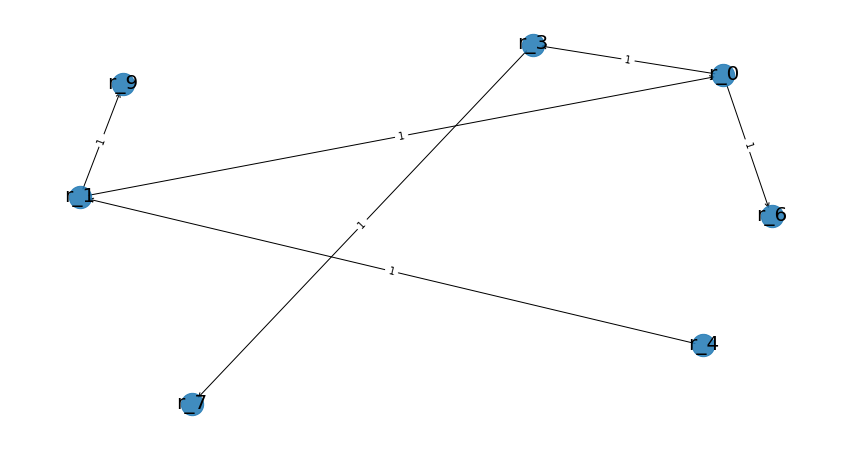

In [159]:
%matplotlib inline
model_hc_k2   = bnlearn.structure_learning.fit(df, methodtype='hc', scoretype='k2')
G = bnlearn.plot(model_hc_k2)
plt.show()

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bdeu]
[bnlearn] >Plot based on BayesianModel


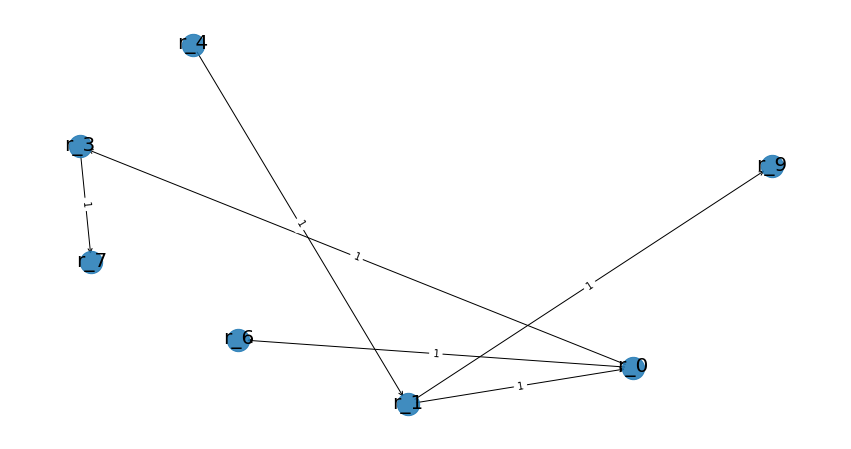

In [160]:
%matplotlib inline
model_hc_bdeu = bnlearn.structure_learning.fit(df, methodtype='hc', scoretype='bdeu')
G = bnlearn.plot(model_hc_bdeu)
plt.show()